In [184]:
'''All the libraries a man needs.'''

import os
import glob
import pandas as pd
import numpy as np
import cv2 
import math
import xml.etree.ElementTree as ET
from skimage.io import imread, imsave
from skimage.transform import resize
# import albumentations
from skimage.feature import hog
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import random 


In [250]:
'''All file paths (probably done very badly but it works)'''

pro_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\ProcessedImages"
pro_folder = os.path.realpath(pro_folder)
raw_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\RawImages"
raw_folder = os.path.realpath(raw_folder)
cropped_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\CroppedImages"
cropped_folder = os.path.realpath(cropped_folder)
rootdir_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations"
rootdir_folder = os.path.realpath(rootdir_folder)
annotations_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\Annotations"
annotations_folder = os.path.realpath(annotations_folder)
images_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\JPEGImages"
images_folder = os.path.realpath(images_folder)
neg_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\NegativeImages"
neg_folder = os.path.realpath(neg_folder)
original_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\OriginalData"
original_folder = os.path.realpath(original_folder)
model_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\Models"
model_folder = os.path.realpath(model_folder)
hnm_folder = r"C:\Users\scott\OneDrive\Desktop\m2cai16-tool-locations\HardNegativeMining"
hnm_folder = os.path.realpath(hnm_folder)


In [278]:
'''Creates dataframe.'''
'''One row: original filename, image dimensions (two columns), class name, bounding box for tool (four columns)'''

os.chdir(annotations_folder)
anno_list = []
path = annotations_folder
counter = 0
for xml_file in glob.glob(path + '/*.xml'):
    counter = counter + 1
    tree = ET.parse(xml_file)
    root = tree.getroot()
    object_found = 0
    for tool in root.findall('object'):
        object_found = 1
        value = (root.find('filename').text,#filename
                    int(root.find('size')[0].text),#image dimensions
                    int(root.find('size')[1].text),
                    tool[0].text,#class
                    int(tool[4][0].text),#box coordinates
                    int(tool[4][1].text),
                    int(tool[4][2].text),
                    int(tool[4][3].text)#box coordinates
                    )
        anno_list.append(value)


column_name = ['filename', 'img_width', 'img_height', 
                'class', 'xmin', 'ymin', 'xmax', 'ymax']

class_cols = ['filename', 'img_width', 'img_height', 
                'class']
#anno_df = pd.DataFrame(anno_list, columns=column_name) #Pandas dataframe with all data from annotations

class_df = pd.DataFrame(anno_list, columns=column_name)

data_points = []
class_df = class_df.reset_index()
print(class_df["class"].value_counts())
print(class_df["filename"].nunique())

df2 = class_df.pivot_table(columns=['filename'], aggfunc='size')
print(df2.sort_values())

Grasper        1422
Irrigator       485
SpecimenBag     476
Bipolar         450
Clipper         400
Scissors        388
Hook            308
Name: class, dtype: int64
2811
filename
v01_002075.jpg    1
v08_002025.jpg    1
v08_001850.jpg    1
v08_001150.jpg    1
v08_000975.jpg    1
                 ..
v03_109000.jpg    4
v05_060025.jpg    4
v05_060150.jpg    4
v09_045200.jpg    4
v03_108875.jpg    4
Length: 2811, dtype: int64


In [ ]:
total_flip = 0
for image in glob.glob(original_folder + '/*flip.jpg'):
    total_flip = total_flip + 1
    # os.remove(image)

print(total_flip)#Gives total number of flipped images.

2248


In [279]:
'''Applies OneHotEncoder to class types and creates new column.'''

enc = OneHotEncoder()
enc.fit(class_df['class'].values.reshape(-1,1))
encoded_classes = np.asarray(enc.transform(class_df['class'].values.reshape(-1,1)).toarray())
print(encoded_classes.shape)
encoded_classes = encoded_classes.tolist()
class_df['Enc. Values'] = encoded_classes
print(class_df)

(3929, 7)
      index        filename  img_width  img_height        class  xmin  ymin  \
0         0  v01_002075.jpg        596         334      Grasper   201   171   
1         1  v01_002250.jpg        596         334      Grasper   155   151   
2         2  v01_002250.jpg        596         334      Grasper   423   154   
3         3  v01_002425.jpg        596         334      Grasper   178   151   
4         4  v01_004050.jpg        596         334      Grasper   240    79   
...     ...             ...        ...         ...          ...   ...   ...   
3924   3924  v10_065125.jpg        578         324  SpecimenBag   327   197   
3925   3925  v10_065150.jpg        578         324  SpecimenBag   125   134   
3926   3926  v10_066100.jpg        578         324  SpecimenBag   106   111   
3927   3927  v10_066100.jpg        578         324      Grasper   163     7   
3928   3928  v10_066125.jpg        578         324  SpecimenBag   126   176   

      xmax  ymax                         

In [280]:
'''Creates multi-label classes for each original image.'''

original_df = pd.DataFrame(columns = ['Filename', 'Multi_label'])
filename = ""
multilabel = []
label_list = []
filename_list = []
for index,row in class_df.iterrows():
    if filename == row["filename"] or index == 0:
        if len(multilabel):
            multilabel = [multilabel[0] + row['Enc. Values'][0], multilabel[1] + row['Enc. Values'][1], multilabel[2] + row['Enc. Values'][2],
                          multilabel[3] + row['Enc. Values'][3], multilabel[4] + row['Enc. Values'][4], multilabel[5] + row['Enc. Values'][5],
                          multilabel[6] + row['Enc. Values'][6]]
        else:
            multilabel = row['Enc. Values']
    else:
        filename_list.append(filename)
        label_list.append(multilabel)
        multilabel = row['Enc. Values']
    filename = row["filename"]
filename_list.append(filename)
label_list.append(multilabel)
original_df['Filename'] = filename_list
original_df['Multi_label'] = label_list
print(original_df)

            Filename                          Multi_label
0     v01_002075.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
1     v01_002250.jpg  [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]
2     v01_002425.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
3     v01_004050.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
4     v01_004225.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
...              ...                                  ...
2806  v10_065025.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
2807  v10_065125.jpg  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
2808  v10_065150.jpg  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
2809  v10_066100.jpg  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
2810  v10_066125.jpg  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

[2811 rows x 2 columns]


In [281]:
'''Creates all cropped images for all tools in images.'''

from PIL import Image

graspList = []
spec_bag_list = []
bipolar_list = []
clipper_list = []
scissors_list = []
hook_list = []
irrigator_list = []

newFileList = []
img_counter = 0
filename = ""

CROPPED_PATH = os.path.join(rootdir_folder,'CroppedImages')
if not os.path.exists(CROPPED_PATH):
    os.mkdir(CROPPED_PATH)
for index,row in class_df.iterrows():
    os.chdir(raw_folder)
    img = Image.open(row["filename"])
    img_crop = img.crop((row["xmin"], row["ymin"], row["xmax"], row["ymax"]))
    if filename == row["filename"]:
        img_counter = img_counter + 1
    else:
        img_counter = 0
    filename = row["filename"]
    newfilename = filename[:-4] + str(img_counter) + ".jpg"
    os.chdir(cropped_folder)
    newFileList.append(newfilename)
    #img_crop.save(newfilename)
    if (row["class"] == "Grasper"):
        graspList.append(newfilename)
    if (row["class"] == "SpecimenBag"):
        spec_bag_list.append(newfilename)
    if (row["class"] == "Bipolar"):
        bipolar_list.append(newfilename)
    if (row["class"] == "Clipper"):
        clipper_list.append(newfilename)
    if (row["class"] == "Scissors"):
        scissors_list.append(newfilename)
    if (row["class"] == "Hook"):
        hook_list.append(newfilename)
    if (row["class"] == "Irrigator"):
        irrigator_list.append(newfilename)
class_df["Cropped File"] = newFileList    
print(class_df)

      index        filename  img_width  img_height        class  xmin  ymin  \
0         0  v01_002075.jpg        596         334      Grasper   201   171   
1         1  v01_002250.jpg        596         334      Grasper   155   151   
2         2  v01_002250.jpg        596         334      Grasper   423   154   
3         3  v01_002425.jpg        596         334      Grasper   178   151   
4         4  v01_004050.jpg        596         334      Grasper   240    79   
...     ...             ...        ...         ...          ...   ...   ...   
3924   3924  v10_065125.jpg        578         324  SpecimenBag   327   197   
3925   3925  v10_065150.jpg        578         324  SpecimenBag   125   134   
3926   3926  v10_066100.jpg        578         324  SpecimenBag   106   111   
3927   3927  v10_066100.jpg        578         324      Grasper   163     7   
3928   3928  v10_066125.jpg        578         324  SpecimenBag   126   176   

      xmax  ymax                          Enc. Valu

In [255]:
print(graspList)
print(spec_bag_list)
print(bipolar_list)
print(clipper_list)
print(scissors_list)
print(hook_list)
print(irrigator_list)

['v01_0020750.jpg', 'v01_0022500.jpg', 'v01_0022501.jpg', 'v01_0024250.jpg', 'v01_0040500.jpg', 'v01_0042250.jpg', 'v01_0044500.jpg', 'v01_0046250.jpg', 'v01_0048000.jpg', 'v01_0048001.jpg', 'v01_0071250.jpg', 'v01_0071251.jpg', 'v01_0201500.jpg', 'v01_0201501.jpg', 'v01_0251501.jpg', 'v01_0252750.jpg', 'v01_0254500.jpg', 'v01_0254501.jpg', 'v01_0256250.jpg', 'v01_0258000.jpg', 'v01_0259750.jpg', 'v01_0264001.jpg', 'v01_0264501.jpg', 'v01_0269251.jpg', 'v01_0273750.jpg', 'v01_0275501.jpg', 'v01_0275502.jpg', 'v01_0275751.jpg', 'v01_0275752.jpg', 'v01_0276000.jpg', 'v01_0276001.jpg', 'v01_0276251.jpg', 'v01_0276252.jpg', 'v01_0276501.jpg', 'v01_0276502.jpg', 'v01_0276750.jpg', 'v01_0276751.jpg', 'v01_0277001.jpg', 'v01_0277002.jpg', 'v01_0277251.jpg', 'v01_0277252.jpg', 'v01_0277500.jpg', 'v01_0277501.jpg', 'v01_0277751.jpg', 'v01_0277752.jpg', 'v01_0278001.jpg', 'v01_0278002.jpg', 'v01_0278250.jpg', 'v01_0278251.jpg', 'v01_0278501.jpg', 'v01_0278502.jpg', 'v01_0278751.jpg', 'v01_027875

In [232]:
reducedList = []
print(len(graspList))
while len(reducedList) < 485:
    randInt = random.randint(0,len(graspList)-1)
    if(graspList[randInt] not in reducedList):
        reducedList.append(graspList[randInt])

print(len(reducedList))
print(reducedList)        

1422
485
['v03_0429500.jpg', 'v03_1070751.jpg', 'v03_0443001.jpg', 'v06_0692501.jpg', 'v08_0160001.jpg', 'v06_0706251.jpg', 'v08_0363751.jpg', 'v03_0546500.jpg', 'v03_0551751.jpg', 'v06_0009500.jpg', 'v03_1086001.jpg', 'v08_0352501.jpg', 'v06_0476751.jpg', 'v01_0286752.jpg', 'v05_0563250.jpg', 'v06_0345000.jpg', 'v06_0767501.jpg', 'v08_0161501.jpg', 'v02_0008250.jpg', 'v09_0443752.jpg', 'v03_1105001.jpg', 'v01_0201501.jpg', 'v02_0017002.jpg', 'v01_0533251.jpg', 'v07_0092500.jpg', 'v06_0629001.jpg', 'v06_0221251.jpg', 'v08_0345751.jpg', 'v01_0556252.jpg', 'v06_0372750.jpg', 'v04_0035500.jpg', 'v10_0208500.jpg', 'v10_0003251.jpg', 'v04_0255751.jpg', 'v06_0662751.jpg', 'v05_0326000.jpg', 'v09_0009500.jpg', 'v02_0433501.jpg', 'v04_0155000.jpg', 'v04_0285501.jpg', 'v06_0029250.jpg', 'v05_0599002.jpg', 'v05_0617251.jpg', 'v06_0647751.jpg', 'v03_0552501.jpg', 'v04_0286751.jpg', 'v06_0665501.jpg', 'v01_0287751.jpg', 'v06_0474501.jpg', 'v06_0661501.jpg', 'v03_0544250.jpg', 'v06_0556500.jpg', 'v

In [190]:
def getReduced(full_list, value):
    print(len(full_list))
    reduced_list = []
    while len(reduced_list) < value:
        randInt = random.randint(0,len(full_list)-1)
        if(full_list[randInt] not in reduced_list):
            reduced_list.append(full_list[randInt])
    print(reduced_list)
    give_list = reduced_list.copy()
    return give_list

In [282]:
'''Skip if reduced in use'''

os.chdir(cropped_folder)
print(class_df["class"].value_counts())
class_df_copy = class_df.copy()
for index, row in class_df_copy.iterrows():
    if row["class"] != "Grasper":
        cropped_img = cv2.imread(row["Cropped File"])
        flipHori = cv2.flip(cropped_img, 1)
        flipHoriFile = row["Cropped File"][:-4] + "Hor.jpg"
        flipVert = cv2.flip(cropped_img, 0)
        flipVertFile = row["Cropped File"][:-4] + "Ver.jpg"
        rotate = random.randint(0, 1)  
        flip = random.randint(0, 1)  
        if rotate == 0:
            rotate_img = cv2.rotate(cropped_img, cv2.ROTATE_90_CLOCKWISE)
        if rotate == 1:
            rotate_img = cv2.rotate(cropped_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        rotateFile = row["Cropped File"][:-4] + "Rot.jpg"
        if os.path.exists(flipHoriFile):
            new_row = {'filename': row["filename"], 'class':row["class"],
                'Cropped File':flipHoriFile}
            class_df_copy = class_df_copy.append(new_row, ignore_index=True)

        if (os.path.exists(flipVertFile)):
            new_row = {'filename': row["filename"],  'class':row["class"],
                'Cropped File':flipVertFile}
            class_df_copy = class_df_copy.append(new_row, ignore_index=True)

        if (os.path.exists(rotateFile)):
            new_row = {'filename': row["filename"], 'class':row["class"],
                'Cropped File':rotateFile}
            class_df_copy = class_df_copy.append(new_row, ignore_index=True)
        #cv2.imwrite(flipHoriFile, flipHori) 
        # if (flip == 1 or row["class"] == "Scissors" or row["class"] == "Hook" ):
        #     cv2.imwrite(flipVertFile, flipVert) 
        # cv2.imwrite(rotateFile, rotate_img) 


class_df = class_df_copy
print(class_df)
print(class_df["class"].value_counts())

Grasper        1422
Irrigator       485
SpecimenBag     476
Bipolar         450
Clipper         400
Scissors        388
Hook            308
Name: class, dtype: int64


C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

      index        filename  img_width  img_height        class   xmin   ymin  \
0       0.0  v01_002075.jpg      596.0       334.0      Grasper  201.0  171.0   
1       1.0  v01_002250.jpg      596.0       334.0      Grasper  155.0  151.0   
2       2.0  v01_002250.jpg      596.0       334.0      Grasper  423.0  154.0   
3       3.0  v01_002425.jpg      596.0       334.0      Grasper  178.0  151.0   
4       4.0  v01_004050.jpg      596.0       334.0      Grasper  240.0   79.0   
...     ...             ...        ...         ...          ...    ...    ...   
6431    NaN  v10_065025.jpg        NaN         NaN  SpecimenBag    NaN    NaN   
6432    NaN  v10_065125.jpg        NaN         NaN  SpecimenBag    NaN    NaN   
6433    NaN  v10_065150.jpg        NaN         NaN  SpecimenBag    NaN    NaN   
6434    NaN  v10_066100.jpg        NaN         NaN  SpecimenBag    NaN    NaN   
6435    NaN  v10_066125.jpg        NaN         NaN  SpecimenBag    NaN    NaN   

       xmax   ymax         

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df_copy = class_df_copy.append(new_row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2466649664.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [9]:
'''Function to find coordinates for one negative (no tool presence) box in an image'''

def findNeg(box_list, im_width, im_height):
    found = False
    while found == False:
        print("IN")
        inbox = False
        randx = random.randint(0, im_width-50)   
        randy = random.randint(0, im_height-50) 
        for box in box_list:
            if ((randx >= box[0] and randx <= box[1] and randy >= box[2] and randy <= box[3]) 
            or (randx + 50 >= box[0] and randx + 50 <= box[1] and randy + 50 >= box[2] and randy + 50 <= box[3])):
                inbox = True
        if inbox == False:
            box_list.append([randx, randx + 50, randy, randy + 50])
            return(randx, randy, box_list)     

In [ ]:
'''Creates two negative (no tool presence) images per original image'''
'''DONT TOUCH'''

from PIL import Image
NEG_PATH = os.path.join(rootdir_folder,'NegativeImages')
if not os.path.exists(NEG_PATH):
    os.mkdir(NEG_PATH)
# negative_df = class_df.copy()
filename = ""
box_list = []

for index, row in class_df.iterrows():
    if filename == row["filename"] or index == 0:
        box_list.append([row["xmin"],row["xmax"],row["ymin"],row["ymax"]])


    else:
        xneg1, yneg1, box_list = findNeg(box_list, row["img_width"], row["img_height"])
        xneg2, yneg2, box_list = findNeg(box_list, row["img_width"], row["img_height"])
        print("IMAGE 1: " + str(xneg1) + " , " + str(yneg1))
        print("IMAGE 2: " + str(xneg2) + " , " + str(yneg2))
        print(box_list)
        os.chdir(raw_folder)
        print(index)
        img = Image.open(filename)
        img_crop1 = img.crop((xneg1, yneg1, xneg1 + 50, yneg1 + 50))
        img_crop2 = img.crop((xneg2, yneg2, xneg2 + 50, yneg2 + 50))
        os.chdir(neg_folder)
        newfile1 = filename[:-4] + "neg1.jpg"
        newfile2 = filename[:-4] + "neg2.jpg"
        img_crop1.save(newfile1)
        img_crop2.save(newfile2)
        box_list = [[row["xmin"], row["xmax"], row["ymin"], row["ymax"]]]    
        print(box_list)    
        print(row["filename"])

    filename = row["filename"]
    if index == 3928:
        print("HEREEEEEE")
        xneg1, yneg1, box_list = findNeg(box_list, row["img_width"], row["img_height"])
        xneg2, yneg2, box_list = findNeg(box_list, row["img_width"], row["img_height"])
        print("IMAGE 1: " + str(xneg1) + " , " + str(yneg1))
        print("IMAGE 2: " + str(xneg2) + " , " + str(yneg2))
        print(box_list)
        os.chdir(raw_folder)
        print(index)
        img = Image.open(filename)
        img_crop1 = img.crop((xneg1, yneg1, xneg1 + 50, yneg1 + 50))
        img_crop2 = img.crop((xneg2, yneg2, xneg2 + 50, yneg2 + 50))
        os.chdir(neg_folder)
        newfile1 = filename[:-4] + "neg1.jpg"
        newfile2 = filename[:-4] + "neg2.jpg"
        img_crop1.save(newfile1)
        img_crop2.save(newfile2)

        

IN
IN
IMAGE 1: 316 , 260
IMAGE 2: 410 , 151
[[201, 256, 171, 191], [316, 366, 260, 310], [410, 460, 151, 201]]
1
[[155, 210, 151, 174]]
v01_002250.jpg
IN
IN
IN
IMAGE 1: 504 , 157
IMAGE 2: 244 , 65
[[155, 210, 151, 174], [423, 487, 154, 287], [504, 554, 157, 207], [244, 294, 65, 115]]
3
[[178, 227, 151, 174]]
v01_002425.jpg
IN
IN
IMAGE 1: 543 , 29
IMAGE 2: 347 , 136
[[178, 227, 151, 174], [543, 593, 29, 79], [347, 397, 136, 186]]
4
[[240, 315, 79, 142]]
v01_004050.jpg
IN
IN
IMAGE 1: 325 , 28
IMAGE 2: 122 , 18
[[240, 315, 79, 142], [325, 375, 28, 78], [122, 172, 18, 68]]
5
[[344, 432, 7, 100]]
v01_004225.jpg
IN
IN
IMAGE 1: 293 , 47
IMAGE 2: 155 , 134
[[344, 432, 7, 100], [293, 343, 47, 97], [155, 205, 134, 184]]
6
[[235, 309, 74, 133]]
v01_004450.jpg
IN
IN
IMAGE 1: 476 , 171
IMAGE 2: 56 , 70
[[235, 309, 74, 133], [476, 526, 171, 221], [56, 106, 70, 120]]
7
[[293, 378, 56, 110]]
v01_004625.jpg
IN
IN
IN
IMAGE 1: 258 , 254
IMAGE 2: 5 , 13
[[293, 378, 56, 110], [258, 308, 254, 304], [5, 55, 

In [257]:
'''Adds all Negative images to dataframe'''

print(os.listdir(neg_folder))
negList = os.listdir(neg_folder)
redNegList = []
print(len(negList))
while len(redNegList) < 1500:
    randNegInt = random.randint(0,len(negList)-1)
    if(negList[randNegInt] not in redNegList):
        redNegList.append(negList[randNegInt])

print(len(redNegList))
print(redNegList)      
for file in (negList):
    new_row1 = {'filename': file[:-8] + ".jpg", 'img_width':50, 'img_height':50, 'class':'Negative',
                'Cropped File':file}
    class_df = class_df.append(new_row1, ignore_index=True)
    
print(class_df)
print(class_df["class"].value_counts())

['v01_002075neg1.jpg', 'v01_002075neg2.jpg', 'v01_002250neg1.jpg', 'v01_002250neg2.jpg', 'v01_002425neg1.jpg', 'v01_002425neg2.jpg', 'v01_004050neg1.jpg', 'v01_004050neg2.jpg', 'v01_004225neg1.jpg', 'v01_004225neg2.jpg', 'v01_004450neg1.jpg', 'v01_004450neg2.jpg', 'v01_004625neg1.jpg', 'v01_004625neg2.jpg', 'v01_004800neg1.jpg', 'v01_004800neg2.jpg', 'v01_007125neg1.jpg', 'v01_007125neg2.jpg', 'v01_017125neg1.jpg', 'v01_017125neg2.jpg', 'v01_018000neg1.jpg', 'v01_018000neg2.jpg', 'v01_020150neg1.jpg', 'v01_020150neg2.jpg', 'v01_025150neg1.jpg', 'v01_025150neg2.jpg', 'v01_025275neg1.jpg', 'v01_025275neg2.jpg', 'v01_025450neg1.jpg', 'v01_025450neg2.jpg', 'v01_025625neg1.jpg', 'v01_025625neg2.jpg', 'v01_025800neg1.jpg', 'v01_025800neg2.jpg', 'v01_025975neg1.jpg', 'v01_025975neg2.jpg', 'v01_026400neg1.jpg', 'v01_026400neg2.jpg', 'v01_026450neg1.jpg', 'v01_026450neg2.jpg', 'v01_026925neg1.jpg', 'v01_026925neg2.jpg', 'v01_027375neg1.jpg', 'v01_027375neg2.jpg', 'v01_027550neg1.jpg', 'v01_0275

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.

       index        filename  img_width  img_height     class   xmin   ymin  \
0        0.0  v01_002075.jpg      596.0       334.0   Grasper  201.0  171.0   
1        1.0  v01_002250.jpg      596.0       334.0   Grasper  155.0  151.0   
2        2.0  v01_002250.jpg      596.0       334.0   Grasper  423.0  154.0   
3        3.0  v01_002425.jpg      596.0       334.0   Grasper  178.0  151.0   
4        4.0  v01_004050.jpg      596.0       334.0   Grasper  240.0   79.0   
...      ...             ...        ...         ...       ...    ...    ...   
12053    NaN  v10_065150.jpg       50.0        50.0  Negative    NaN    NaN   
12054    NaN  v10_066100.jpg       50.0        50.0  Negative    NaN    NaN   
12055    NaN  v10_066100.jpg       50.0        50.0  Negative    NaN    NaN   
12056    NaN  v10_066125.jpg       50.0        50.0  Negative    NaN    NaN   
12057    NaN  v10_066125.jpg       50.0        50.0  Negative    NaN    NaN   

        xmax   ymax                          Enc. V

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1765546090.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_df = class_df.

In [258]:
red_spec = getReduced(spec_bag_list,9)
red_bipo = getReduced(bipolar_list,35)
red_clip = getReduced(clipper_list,85)
red_scis = getReduced(scissors_list,97)
red_hook = getReduced(hook_list,177)
# graspList = getReduced(graspList, 485)
print(red_hook)




476
['v10_0649000.jpg', 'v07_0285000.jpg', 'v06_0672500.jpg', 'v01_0571000.jpg', 'v05_0555000.jpg', 'v05_0555750.jpg', 'v07_0292750.jpg', 'v09_0444750.jpg', 'v10_0611000.jpg']
450
['v07_0311000.jpg', 'v04_0049500.jpg', 'v08_0344000.jpg', 'v06_0717000.jpg', 'v08_0205250.jpg', 'v02_0186000.jpg', 'v08_0161000.jpg', 'v06_0474500.jpg', 'v06_0377500.jpg', 'v04_0264000.jpg', 'v02_0186250.jpg', 'v06_0160750.jpg', 'v08_0303500.jpg', 'v08_0300250.jpg', 'v04_0204000.jpg', 'v08_0303250.jpg', 'v08_0062750.jpg', 'v08_0351000.jpg', 'v02_0189750.jpg', 'v08_0342750.jpg', 'v04_0201000.jpg', 'v06_0713250.jpg', 'v07_0334000.jpg', 'v06_0219000.jpg', 'v08_0209000.jpg', 'v08_0067000.jpg', 'v02_0442750.jpg', 'v06_0709750.jpg', 'v08_0302750.jpg', 'v08_0341250.jpg', 'v04_0204250.jpg', 'v04_0265500.jpg', 'v02_0190000.jpg', 'v08_0202000.jpg', 'v06_0222000.jpg']
400
['v03_0470250.jpg', 'v03_0496500.jpg', 'v03_0463250.jpg', 'v03_0476750.jpg', 'v03_0501500.jpg', 'v07_0184750.jpg', 'v02_0243000.jpg', 'v10_0321250.jpg

In [63]:
print(red_bipo)
print(len(red_bipo))

['v02_0193000.jpg', 'v08_0066750.jpg', 'v08_0205750.jpg', 'v06_0474500.jpg', 'v07_0333000.jpg', 'v06_0516500.jpg', 'v06_0430500.jpg', 'v08_0352250.jpg', 'v04_0263750.jpg', 'v07_0310000.jpg', 'v04_0265250.jpg', 'v06_0476750.jpg', 'v07_0334000.jpg', 'v04_0203750.jpg', 'v07_0330750.jpg', 'v06_0760750.jpg', 'v08_0205000.jpg', 'v04_0202250.jpg', 'v06_0704250.jpg', 'v04_0265500.jpg', 'v04_0046500.jpg', 'v04_0254250.jpg', 'v06_0435000.jpg', 'v08_0344000.jpg', 'v04_0266500.jpg', 'v08_0066500.jpg', 'v04_0252250.jpg', 'v08_0207750.jpg', 'v04_0255500.jpg', 'v04_0260750.jpg', 'v04_0202000.jpg', 'v08_0209000.jpg', 'v06_0433500.jpg', 'v08_0206500.jpg', 'v04_0264750.jpg']
35


In [283]:
for spec in red_spec:
    spec_bag_list.append(spec[:-4] + "Hor.jpg")
for bipo in red_bipo:
    bipolar_list.append(bipo[:-4] + "Hor.jpg")
for clip in red_clip:
    clipper_list.append(clip[:-4] + "Hor.jpg")
for scis in red_scis:
    scissors_list.append(scis[:-4] + "Hor.jpg")
for hook in red_hook:
    hook_list.append(hook[:-4] + "Hor.jpg")

In [260]:
print(len(spec_bag_list))
print(len(bipolar_list))
print(len(clipper_list))
print(len(scissors_list))
print(len(hook_list))
print(spec_bag_list)

485
485
485
485
485
['v01_0538500.jpg', 'v01_0539750.jpg', 'v01_0541000.jpg', 'v01_0542250.jpg', 'v01_0543500.jpg', 'v01_0544750.jpg', 'v01_0546000.jpg', 'v01_0547250.jpg', 'v01_0548500.jpg', 'v01_0549750.jpg', 'v01_0551000.jpg', 'v01_0552250.jpg', 'v01_0553500.jpg', 'v01_0554750.jpg', 'v01_0556000.jpg', 'v01_0556250.jpg', 'v01_0557500.jpg', 'v01_0557750.jpg', 'v01_0559000.jpg', 'v01_0559250.jpg', 'v01_0565000.jpg', 'v01_0565250.jpg', 'v01_0565500.jpg', 'v01_0565750.jpg', 'v01_0566000.jpg', 'v01_0566250.jpg', 'v01_0566500.jpg', 'v01_0566750.jpg', 'v01_0567000.jpg', 'v01_0567250.jpg', 'v01_0567500.jpg', 'v01_0567750.jpg', 'v01_0568000.jpg', 'v01_0568250.jpg', 'v01_0568500.jpg', 'v01_0568750.jpg', 'v01_0569000.jpg', 'v01_0569250.jpg', 'v01_0569500.jpg', 'v01_0569750.jpg', 'v01_0570000.jpg', 'v01_0570250.jpg', 'v01_0570500.jpg', 'v01_0570750.jpg', 'v01_0571000.jpg', 'v01_0571250.jpg', 'v01_0576750.jpg', 'v02_0408000.jpg', 'v02_0408250.jpg', 'v02_0409500.jpg', 'v02_0409750.jpg', 'v02_04110

In [284]:
red_class_df = class_df.copy()
reduced_df = pd.DataFrame()
for index, row in red_class_df.iterrows():
    if row["class"] == "Grasper":
        if row["Cropped File"] in  graspList:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "SpecimenBag":
        if row["Cropped File"] in  spec_bag_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "Bipolar":
        if row["Cropped File"] in  bipolar_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "Clipper":
        if row["Cropped File"] in  clipper_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "Scissors":
        if row["Cropped File"] in  scissors_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "Hook":
        if row["Cropped File"] in  hook_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
    if row["class"] == "Irrigator":
        if row["Cropped File"] in  irrigator_list:
            reduced_df = reduced_df.append(row, ignore_index=True)
print(reduced_df)
print(reduced_df["class"].value_counts())

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1558977217.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1558977217.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1558977217.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(row, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1558977217.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.

      index        filename  img_width  img_height        class   xmin   ymin  \
0       0.0  v01_002075.jpg      596.0       334.0      Grasper  201.0  171.0   
1       1.0  v01_002250.jpg      596.0       334.0      Grasper  155.0  151.0   
2       2.0  v01_002250.jpg      596.0       334.0      Grasper  423.0  154.0   
3       3.0  v01_002425.jpg      596.0       334.0      Grasper  178.0  151.0   
4       4.0  v01_004050.jpg      596.0       334.0      Grasper  240.0   79.0   
...     ...             ...        ...         ...          ...    ...    ...   
4327    NaN  v10_052825.jpg        NaN         NaN         Hook    NaN    NaN   
4328    NaN  v10_056225.jpg        NaN         NaN         Hook    NaN    NaN   
4329    NaN  v10_058375.jpg        NaN         NaN         Hook    NaN    NaN   
4330    NaN  v10_061100.jpg        NaN         NaN  SpecimenBag    NaN    NaN   
4331    NaN  v10_064900.jpg        NaN         NaN  SpecimenBag    NaN    NaN   

       xmax   ymax         

In [285]:

negList = os.listdir(neg_folder)
negList = getReduced(negList,3000)
for file in (negList):
    new_row1 = {'filename': file[:-8] + ".jpg", 'img_width':50, 'img_height':50, 'class':'Negative',
                'Cropped File':file}
    reduced_df = reduced_df.append(new_row1, ignore_index=True)
    

5622
['v10_034300neg2.jpg', 'v06_038325neg1.jpg', 'v08_016100neg2.jpg', 'v02_045200neg2.jpg', 'v03_098275neg1.jpg', 'v03_054000neg1.jpg', 'v03_090050neg2.jpg', 'v08_022225neg2.jpg', 'v04_005275neg1.jpg', 'v03_051875neg2.jpg', 'v04_028675neg1.jpg', 'v03_055375neg1.jpg', 'v02_045425neg2.jpg', 'v10_024900neg2.jpg', 'v06_070775neg2.jpg', 'v08_000800neg1.jpg', 'v09_045850neg2.jpg', 'v06_055650neg2.jpg', 'v03_044950neg1.jpg', 'v08_018400neg2.jpg', 'v07_017250neg2.jpg', 'v10_020850neg2.jpg', 'v03_059450neg2.jpg', 'v04_029325neg1.jpg', 'v06_072375neg1.jpg', 'v05_059775neg1.jpg', 'v03_107525neg1.jpg', 'v10_016175neg2.jpg', 'v09_037925neg1.jpg', 'v02_026725neg2.jpg', 'v08_030025neg2.jpg', 'v09_013850neg2.jpg', 'v03_108200neg1.jpg', 'v08_020975neg2.jpg', 'v04_003550neg1.jpg', 'v01_028125neg1.jpg', 'v01_027875neg2.jpg', 'v06_076575neg2.jpg', 'v01_056600neg1.jpg', 'v06_033975neg2.jpg', 'v10_051225neg1.jpg', 'v08_013650neg2.jpg', 'v07_028950neg2.jpg', 'v03_016525neg1.jpg', 'v06_063075neg2.jpg', 'v08

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2582392347.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2582392347.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2582392347.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\2582392347.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df =

In [286]:

hnm_list = os.listdir(hnm_folder)
hnm_list = getReduced(hnm_list, 4000)
for file in (hnm_list):
    new_row1 = {'filename': file[:-9] + ".jpg", 'class':'Negative',
                'Cropped File':file}
    reduced_df = reduced_df.append(new_row1, ignore_index=True)

8860
['v08_017375HNM03.jpg', 'v07_031000HNM04.jpg', 'v08_022075HNM10.jpg', 'v03_052900HNM00.jpg', 'v03_001150HNM02.jpg', 'v10_022525HNM00.jpg', 'v03_049200HNM13.jpg', 'v08_020650HNM14.jpg', 'v06_059700HNM00.jpg', 'v02_043950HNM07.jpg', 'v09_025375HNM06.jpg', 'v02_025225HNM12.jpg', 'v04_015650HNM02.jpg', 'v02_019725HNM02.jpg', 'v09_044600HNM00.jpg', 'v05_031425HNM27.jpg', 'v04_025825HNM00.jpg', 'v03_048500HNM05.jpg', 'v03_053350HNM02.jpg', 'v06_071825HNM02.jpg', 'v08_024100HNM04.jpg', 'v04_026425HNM07.jpg', 'v02_011750HNM02.jpg', 'v04_013850HNM04.jpg', 'v01_052300HNM00.jpg', 'v03_102550HNM05.jpg', 'v08_022575HNM06.jpg', 'v03_057050HNM00.jpg', 'v07_028175HNM01.jpg', 'v03_051225HNM00.jpg', 'v08_024450HNM06.jpg', 'v04_025850HNM12.jpg', 'v08_019700HNM03.jpg', 'v06_042475HNM02.jpg', 'v02_019775HNM04.jpg', 'v06_072325HNM00.jpg', 'v01_030575HNM01.jpg', 'v02_042125HNM07.jpg', 'v08_019825HNM02.jpg', 'v03_046725HNM03.jpg', 'v08_019175HNM06.jpg', 'v01_056700HNM00.jpg', 'v03_001500HNM06.jpg', 'v08_

C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1727670784.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1727670784.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1727670784.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(new_row1, ignore_index=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_18092\1727670784.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df =

In [287]:
print(reduced_df)
print(reduced_df["class"].value_counts())

       index        filename  img_width  img_height     class   xmin   ymin  \
0        0.0  v01_002075.jpg      596.0       334.0   Grasper  201.0  171.0   
1        1.0  v01_002250.jpg      596.0       334.0   Grasper  155.0  151.0   
2        2.0  v01_002250.jpg      596.0       334.0   Grasper  423.0  154.0   
3        3.0  v01_002425.jpg      596.0       334.0   Grasper  178.0  151.0   
4        4.0  v01_004050.jpg      596.0       334.0   Grasper  240.0   79.0   
...      ...             ...        ...         ...       ...    ...    ...   
11327    NaN  v02_026100.jpg        NaN         NaN  Negative    NaN    NaN   
11328    NaN  v08_034450.jpg        NaN         NaN  Negative    NaN    NaN   
11329    NaN  v02_025375.jpg        NaN         NaN  Negative    NaN    NaN   
11330    NaN  v02_044275.jpg        NaN         NaN  Negative    NaN    NaN   
11331    NaN  v03_047950.jpg        NaN         NaN  Negative    NaN    NaN   

        xmax   ymax                          Enc. V

In [288]:
original_df = original_df[original_df.Filename !=  "v01_035325.jpg"]
print(original_df["Multi_label"].value_counts())

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    385
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]    307
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    299
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    264
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    245
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    221
[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    205
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]    185
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    175
[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]    101
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]    100
[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0]     96
[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]     79
[0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0]     63
[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]     61
[0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0]     20
[0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0]      4
Name: Multi_label, dtype: int64


In [289]:
'''Train-test split on original images.'''

X_train, X_test, y_train, y_test = train_test_split((np.asarray(original_df["Filename"])), (np.asarray(original_df["Multi_label"])), test_size = 0.2,random_state=22, shuffle=True, stratify=(np.asarray(original_df["Multi_label"])))
#X_train, y_train, X_test, y_test = iterative_train_test_split((np.asarray(original_df["Filename"])), (np.asarray(original_df["Multi_label"])), test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2248,)
(2248,)
(562,)
(562,)


In [290]:
'''Shows split of multi-label data between train and test data'''

train_df = pd.DataFrame(columns = ['Filename', 'Multi-label'])
train_df["Filename"] = X_train
train_df["Multi-label"] = y_train
test_df = pd.DataFrame(columns = ['Filename', 'Multi-label'])
test_df["Filename"] = X_test
test_df["Multi-label"] = y_test
# print(train_df)
# print(test_df)
print(train_df["Multi-label"].value_counts())
print(test_df["Multi-label"].value_counts())
compare_df = pd.DataFrame(columns = ['Filename', 'Multi-label'])
print(X_train)

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    308
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]    246
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    239
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    211
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    196
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    177
[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    164
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]    148
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    140
[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]     81
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]     80
[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0]     77
[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]     63
[0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0]     50
[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]     49
[0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0]     16
[0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0]      3
Name: Multi-label, dtype: int64
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    77
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]    61
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    60
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    53
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    49
[0.0, 0.0, 1.0, 0.0, 0.0, 0

In [291]:
'''Extracts rows for train dataset and validates that classes are correctly represented.'''

train_df = reduced_df.copy()
test_df = reduced_df.copy()
rows = []
train_df.drop(columns="index")
for index, row in train_df.iterrows():
    if row["filename"] not in X_train:
        train_df.drop(index, inplace=True) 
    else:
        test_df.drop(index, inplace=True)
train_df = train_df.reset_index()
test_df = test_df.reset_index()
print(train_df["class"].value_counts())

print(class_df["class"].value_counts())
print(train_df)    

Negative       6418
Grasper        1136
Scissors        391
Hook            390
SpecimenBag     389
Clipper         388
Bipolar         388
Irrigator       388
Name: class, dtype: int64
Grasper        1422
Irrigator       970
SpecimenBag     952
Bipolar         900
Clipper         800
Scissors        776
Hook            616
Name: class, dtype: int64
      level_0  index        filename  img_width  img_height     class   xmin  \
0           0    0.0  v01_002075.jpg      596.0       334.0   Grasper  201.0   
1           1    1.0  v01_002250.jpg      596.0       334.0   Grasper  155.0   
2           2    2.0  v01_002250.jpg      596.0       334.0   Grasper  423.0   
3           3    3.0  v01_002425.jpg      596.0       334.0   Grasper  178.0   
4           5    5.0  v01_004225.jpg      596.0       334.0   Grasper  344.0   
...       ...    ...             ...        ...         ...       ...    ...   
9883    11327    NaN  v02_026100.jpg        NaN         NaN  Negative    NaN   
9884    

In [199]:
'''Function to find HOG feature descriptors'''

def hogTransform(img):
    hog_img = hog(
    img, pixels_per_cell=(5,5), 
    cells_per_block=(2, 2), 
    orientations=9, 
    block_norm='L2-Hys',
    # visualize=True, 
    transform_sqrt=True)
    return (hog_img)

In [102]:
tester = os.listdir(hnm_folder)[0]
print(tester[-9:-6])



HNM


In [292]:
'''Images are read in, grey-scaled, resized and hog-transformed.'''
'''A 1D feature descriptor is added to the dataframe for each image.'''

data = []
os.chdir(cropped_folder)
for index, row in train_df.iterrows():
    if row["Cropped File"].endswith("neg1.jpg") or row["Cropped File"].endswith("neg2.jpg"):
        os.chdir(neg_folder)
        
    elif row["Cropped File"][-9:-6] == "HNM":
        os.chdir(hnm_folder)
    else:
        os.chdir(cropped_folder)
    img = cv2.imread(row["Cropped File"], 0)
    img = resize(img, (50,50))
    hog_img = hogTransform(img)
    data.append(hog_img)

train_df["Data"] = data
print(train_df)

      level_0  index        filename  img_width  img_height     class   xmin  \
0           0    0.0  v01_002075.jpg      596.0       334.0   Grasper  201.0   
1           1    1.0  v01_002250.jpg      596.0       334.0   Grasper  155.0   
2           2    2.0  v01_002250.jpg      596.0       334.0   Grasper  423.0   
3           3    3.0  v01_002425.jpg      596.0       334.0   Grasper  178.0   
4           5    5.0  v01_004225.jpg      596.0       334.0   Grasper  344.0   
...       ...    ...             ...        ...         ...       ...    ...   
9883    11327    NaN  v02_026100.jpg        NaN         NaN  Negative    NaN   
9884    11328    NaN  v08_034450.jpg        NaN         NaN  Negative    NaN   
9885    11329    NaN  v02_025375.jpg        NaN         NaN  Negative    NaN   
9886    11330    NaN  v02_044275.jpg        NaN         NaN  Negative    NaN   
9887    11331    NaN  v03_047950.jpg        NaN         NaN  Negative    NaN   

       ymin   xmax   ymax              

In [293]:
print(reduced_df["class"].value_counts())

Negative       7000
Grasper        1422
Hook            485
Clipper         485
Scissors        485
SpecimenBag     485
Bipolar         485
Irrigator       485
Name: class, dtype: int64


In [294]:
'''SVM is imported.'''
'''Data is formatted correctly for model training. This includes the use of OneHotEncoder to represent the classes.'''

from sklearn import svm

enc.fit(train_df['class'].values.reshape(-1,1))

X_data = list(np.asarray(train_df['Data']))
Y_data = np.asarray(enc.transform(train_df['class'].values.reshape(-1,1)).toarray())
Y_train_svm = np.argmax(Y_data, axis=1)

In [295]:
'''SVM model is trained.'''

clf = svm.SVC(probability=True, C=10, gamma = 0.01)
clf.fit(X_data, Y_train_svm)

SVC(C=10, gamma=0.01, probability=True)

In [175]:
import pickle
os.chdir(model_folder)
pickle.dump(clf, open('reducedSVMv2HNMv2.pkl', 'wb'))

In [ ]:
import pickle
os.chdir(model_folder)
clf = pickle.load(open('reducedSVMv2.pkl', 'rb'))

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svm.SVC(probability=True),param_grid,refit=True,verbose=2, n_jobs=-1)
grid.fit(X_data, Y_train_svm)

print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVC(C=10, gamma=0.01, probability=True)


In [296]:
'''Test images are processed (same as training data).'''

test_data = []
os.chdir(cropped_folder)
for index, row in test_df.iterrows():
    if row["Cropped File"].endswith("neg1.jpg") or row["Cropped File"].endswith("neg2.jpg"):
        os.chdir(neg_folder)
    else:
        os.chdir(cropped_folder)
    img = cv2.imread(row["Cropped File"], 0)
    img = resize(img, (50,50))
    hog_img = hogTransform(img)
    test_data.append(hog_img)

test_df["Data"] = test_data
print(test_df)

      level_0  index        filename  img_width  img_height     class   xmin  \
0           4    4.0  v01_004050.jpg      596.0       334.0   Grasper  240.0   
1           7    7.0  v01_004625.jpg      596.0       334.0   Grasper  293.0   
2          14   14.0  v01_020150.jpg      596.0       334.0   Grasper   92.0   
3          15   15.0  v01_020150.jpg      596.0       334.0   Grasper  267.0   
4          22   22.0  v01_025800.jpg      596.0       334.0   Grasper  232.0   
...       ...    ...             ...        ...         ...       ...    ...   
1439     7286    NaN  v04_019000.jpg       50.0        50.0  Negative    NaN   
1440     7288    NaN  v02_048650.jpg       50.0        50.0  Negative    NaN   
1441     7290    NaN  v08_020325.jpg       50.0        50.0  Negative    NaN   
1442     7308    NaN  v05_032375.jpg       50.0        50.0  Negative    NaN   
1443     7312    NaN  v04_004850.jpg       50.0        50.0  Negative    NaN   

       ymin   xmax   ymax              

In [297]:
print(test_df["class"].value_counts())

Negative       582
Grasper        286
Irrigator       97
Bipolar         97
Clipper         97
SpecimenBag     96
Hook            95
Scissors        94
Name: class, dtype: int64


In [298]:
'''Test data is correctly formatted.'''
'''Model predicts targets for test data and root mean squared error is calculated.'''

enc.fit(test_df['class'].values.reshape(-1,1))

X_data_test = list(np.asarray(test_df['Data']))
Y_data_test = np.asarray(enc.transform(test_df['class'].values.reshape(-1,1)).toarray())


svm_predicted = clf.predict(X_data_test)

svm_targets = np.argmax(Y_data_test, axis=1)
test_SVM_mse = mean_squared_error(svm_targets, svm_predicted)
test_SVM_rsme=np.sqrt(test_SVM_mse)
print(test_SVM_rsme)

1.6501489901674613


In [299]:
'''Confusion matrix for multi-class classifier is presented along with the classification report for the model.'''

label_names = [0,1,2,3,4,5,6,7]

cmx_SVM = confusion_matrix(svm_targets, svm_predicted, labels=label_names)
df_SVM = pd.DataFrame(cmx_SVM, columns=label_names, index=label_names)
df_SVM.columns.name = 'prediction'
df_SVM.index.name = 'label'
print(df_SVM)
print(classification_report(svm_targets, svm_predicted))

prediction   0   1    2   3   4    5   6   7
label                                       
0           55   3    9   2   5   16   3   4
1            3  59    7   3   3   12   4   6
2            6   2  200   1   1   69   3   4
3            1   3    4  58   2   24   0   3
4            4   3    2   0  67   16   2   3
5            4   0    2   0   0  574   0   2
6            6   5    8   1   6   24  43   1
7            3   8    9   0   3   18   1  54
              precision    recall  f1-score   support

           0       0.67      0.57      0.61        97
           1       0.71      0.61      0.66        97
           2       0.83      0.70      0.76       286
           3       0.89      0.61      0.72        95
           4       0.77      0.69      0.73        97
           5       0.76      0.99      0.86       582
           6       0.77      0.46      0.57        94
           7       0.70      0.56      0.62        96

    accuracy                           0.77      1444
   macro

In [134]:
'''Sliding window function.'''
'''The image (2D array), window dimensions and step increment dimensions are given.'''
'''The function returns a list of cropped images (the image at each window).'''

def slidingWindow(image, window_width, window_height, x_step_size, y_step_size):
    img_list = []
    # image = imread(file_name, as_gray = True)
    img_width =  image.shape[1]
    img_height = image.shape[0]
    ip_row = math.ceil((img_width - window_width) / x_step_size) + 1 #Iterations per row (Plus one accounts for range starting from 0, not 1)
    ip_column = math.ceil((img_height - window_height) / y_step_size) + 1 #Iterations per column (Plus one accounts for range starting from 0, not 1)
    for y in range(ip_column):
        for x in range(ip_row):
            x_win_pos = x*x_step_size
            y_win_pos = y*y_step_size
            if (x_win_pos + window_width > img_width):
                x_win_pos = img_width - window_width
            if (y_win_pos + window_height > img_height):
                y_win_pos = img_height - window_height
            img_crop = image[ y_win_pos:(y_win_pos + window_height),x_win_pos : (x_win_pos + window_width)]
            img_list.append(((x_win_pos, y_win_pos, x_win_pos + window_width, y_win_pos + window_height), img_crop))
    return(img_list)

In [ ]:
os.chdir(raw_folder)
test_image = cv2.imread("v01_002075.jpg")
img_list = slidingWindow(test_image, 25,50,25,25)

596
334
24
13


In [ ]:
cv2.destroyAllWindows()

In [136]:
'''The image pyramid function.'''
'''An image, scale factor and iterations are given.'''
'''The function returns a list of images in descending order of size.'''

def imagePyramid(image, scale_factor, iterations):
    imgpyr_list = []
    for i in range(iterations):
        div_val = pow(scale_factor,i)
        new_image = resize(image, (image.shape[0]//div_val,image.shape[1]//div_val))
        imgpyr_list.append((div_val,new_image))
    return(imgpyr_list)    

In [308]:
os.chdir(raw_folder)
test_image = cv2.imread("v09_013325.jpg")
img_list = imagePyramid(test_image, 1.4, 5)
for im in img_list:
    print(im[1].shape)

(454, 810, 3)
(324, 578, 3)
(231, 413, 3)
(165, 295, 3)
(118, 210, 3)


In [354]:
def findBoxes(filename, window_width, window_height):
    os.chdir(raw_folder)
    image = cv2.imread(filename, 0)
    pred_boxes = []
    for pyr_tpl in imagePyramid(image,1.4,6):
        pyr_img = pyr_tpl[1]
        pyr_scale = pyr_tpl[0]
        stepx = 10
        stepy = 10
        print(pyr_scale)
        # if pyr_scale > 2:
        #     stepx = 10
        #     stepy = 10
        for window_tpl in slidingWindow(pyr_img,window_width,window_height,stepx,stepy):
            prob = 0
            win_img = window_tpl[1]
            win_box = window_tpl[0]
            img = resize(win_img, (50,50))
            hog_img = hogTransform(img)
            prob_list = test_clf.predict_proba((hog_img).reshape(1, -1))[0]
            for index in range(len(prob_list)):
                if prob < prob_list[index]:
                    pos = index
                    prob = prob_list[index]
            if prob >0.97 and pos!=5 and pos != 7:
                # cv2.imshow("Box Img", win_img)
                # cv2.waitKey(0)
                print((prob,pos)) 
                #clf.predict_proba((hog_img).reshape(1, -1))
                pred_boxes.append(((math.ceil(win_box[0]*pyr_scale), math.ceil(win_box[1]*pyr_scale), math.ceil(win_box[2]*pyr_scale), math.ceil(win_box[3]*pyr_scale)),pos,prob))
            
            # cv2.imshow("img",win_img)
            # cv2.waitKey(0)
            # hog_img = hogTransform(img)

            #     clone = image.copy()
            #     clone = cv2.rectangle(clone, (x_win_pos, y_win_pos), (x_win_pos + window_width, y_win_pos + window_height), (0, 255, 0), 2)
            #     plt.imshow(clone)
            #     plt.show()
    return(pred_boxes)

In [138]:
def IoU (box1, box2):
    #Calculates area of given boxes
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    #Calculates corners of intersecting box
    xtopL = max(box1[0], box2[0])
    ytopL = max(box1[1], box2[1])
    xbotR = min(box1[2], box2[2])
    ybotR = min(box1[3], box2[3])

    #Calculates area of intersecting box (gives 0 if intersecting box doesn't exist)
    interArea = max(0, xbotR - xtopL + 1) * max(0, ybotR - ytopL + 1)

    #Calculates intersection over union
    iou = interArea / float(box1Area + box2Area - interArea)
    
    return iou

In [139]:
def nms(boxes):
    box_list = boxes.copy()
    box_list.sort(key = lambda i:i[2], reverse = True)
    new_list = []
    while len(box_list) != 0:
        new_box = box_list[0]
        new_list.append(box_list[0])
        box_list.remove(box_list[0])
        box_list_copy = box_list.copy()
        for box in box_list:
            if (IoU(new_box[0],box[0])) > 0:
                box_list_copy.remove(box)
        box_list = box_list_copy
    return new_list 

In [140]:
def drawBox(image, box, colour, name):
    clone = image.copy()
    clone = cv2.rectangle(clone, (box[0], box[1]), (box[2], box[3]), colour, 2)
    clone = cv2.putText(clone, name, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    return clone
    

In [141]:
def saveImg(filename, box, index,folder):
    os.chdir(raw_folder)
    if index < 10:
        str_index = "0" + str(index)
    elif index > 99:
        print("EXCEEDED RANGE")    
    else:
        str_index = str(index)    
    img = Image.open(filename)
    img_crop = img.crop((box[0], box[1], box[2], box[3]))
    
    newfile = filename[:-4] + "HNM" + str_index + ".jpg"
    os.chdir(folder)
    img_crop.save(newfile)
    

In [210]:
test_imgs = []

for index, row in test_df.iterrows():
    test_imgs.append(row["filename"])

print(test_imgs)    

['v01_004050.jpg', 'v01_004625.jpg', 'v01_020150.jpg', 'v01_020150.jpg', 'v01_025800.jpg', 'v01_027675.jpg', 'v01_027675.jpg', 'v01_027675.jpg', 'v01_027725.jpg', 'v01_027725.jpg', 'v01_027725.jpg', 'v01_027775.jpg', 'v01_027775.jpg', 'v01_027775.jpg', 'v01_028150.jpg', 'v01_028150.jpg', 'v01_028150.jpg', 'v01_028225.jpg', 'v01_028225.jpg', 'v01_028225.jpg', 'v01_028275.jpg', 'v01_028275.jpg', 'v01_028275.jpg', 'v01_028450.jpg', 'v01_028450.jpg', 'v01_028450.jpg', 'v01_028525.jpg', 'v01_028525.jpg', 'v01_028525.jpg', 'v01_028625.jpg', 'v01_028625.jpg', 'v01_028625.jpg', 'v01_028775.jpg', 'v01_028775.jpg', 'v01_028775.jpg', 'v01_029325.jpg', 'v01_029325.jpg', 'v01_035325.jpg', 'v01_035325.jpg', 'v01_042300.jpg', 'v01_046350.jpg', 'v01_053150.jpg', 'v01_053975.jpg', 'v01_053975.jpg', 'v01_053975.jpg', 'v01_053975.jpg', 'v01_054475.jpg', 'v01_054475.jpg', 'v01_054475.jpg', 'v01_054600.jpg', 'v01_054600.jpg', 'v01_054600.jpg', 'v01_054600.jpg', 'v01_054725.jpg', 'v01_054725.jpg', 'v01_0547

In [341]:
os.chdir(raw_folder)
test_image = "v02_019275.jpg"

def findTruths(filename):
    truth_boxes = []
    for index, row in class_df.iterrows():
        if row["filename"] == filename and row["class"] != "Negative" and not pd.isnull(row["xmin"]):
            truth_boxes.append(((int(row["xmin"]),int(row["ymin"]),int(row["xmax"]),int(row["ymax"])),row["class"]))
    return truth_boxes

truth_boxes = findTruths(test_image)
print(truth_boxes)

[((311, 243, 541, 377), 'Bipolar')]


In [58]:
train_imgs = []

for index, row in train_df.iterrows():
    train_imgs.append(row["filename"])
train_imgs = list(dict.fromkeys(train_imgs))    
print(train_imgs)    

['v01_002075.jpg', 'v01_002250.jpg', 'v01_002425.jpg', 'v01_004225.jpg', 'v01_004450.jpg', 'v01_004800.jpg', 'v01_007125.jpg', 'v01_017125.jpg', 'v01_018000.jpg', 'v01_025150.jpg', 'v01_025275.jpg', 'v01_025450.jpg', 'v01_025625.jpg', 'v01_025975.jpg', 'v01_026400.jpg', 'v01_026450.jpg', 'v01_026925.jpg', 'v01_027375.jpg', 'v01_027550.jpg', 'v01_027575.jpg', 'v01_027600.jpg', 'v01_027625.jpg', 'v01_027650.jpg', 'v01_027700.jpg', 'v01_027750.jpg', 'v01_027800.jpg', 'v01_027825.jpg', 'v01_027850.jpg', 'v01_027875.jpg', 'v01_027900.jpg', 'v01_027925.jpg', 'v01_027950.jpg', 'v01_027975.jpg', 'v01_028000.jpg', 'v01_028025.jpg', 'v01_028050.jpg', 'v01_028075.jpg', 'v01_028100.jpg', 'v01_028125.jpg', 'v01_028175.jpg', 'v01_028200.jpg', 'v01_028250.jpg', 'v01_028300.jpg', 'v01_028325.jpg', 'v01_028350.jpg', 'v01_028375.jpg', 'v01_028400.jpg', 'v01_028425.jpg', 'v01_028475.jpg', 'v01_028500.jpg', 'v01_028550.jpg', 'v01_028575.jpg', 'v01_028600.jpg', 'v01_028650.jpg', 'v01_028675.jpg', 'v01_0287

In [60]:
counter = 0
for hnm_image in train_imgs:
    counter = counter + 1
    print("IMAGE:" + str(counter) + "/" + str(len(train_imgs)))
    index = 0
    truth_boxes = findTruths(hnm_image)
    pred_boxes_sqr = findBoxes(hnm_image, 50, 50)
    pred_boxes_rect = findBoxes(hnm_image, 50, 25)
    concat_boxes = pred_boxes_rect + pred_boxes_sqr
    for box in concat_boxes:
        dont_save = 0
        for truth in truth_boxes:
            iou = IoU(box[0], truth[0])
            if iou > 0:
                dont_save = 1
        if dont_save == 0:
            saveImg(hnm_image, box[0],index,hnm_folder)  
            index = index + 1   

IMAGE:1/2248
(0.9599240372350504, 4)
(0.9579290761729861, 4)
(0.9689298716718041, 2)
IMAGE:2/2248
(0.964396479523137, 2)
(0.9692104161057951, 4)
(0.9607436830691476, 2)
(0.9542670631084094, 2)
(0.9877217159413677, 3)
(0.9834203989863278, 3)
IMAGE:3/2248
(0.95196704556607, 2)
(0.9616001995893262, 4)
(0.9513101401739814, 2)
(0.9658507633834925, 3)
IMAGE:4/2248
(0.9591146115720174, 2)
(0.9627787689342413, 2)
(0.9531177089750941, 2)
(0.9658761067359857, 2)
IMAGE:5/2248
(0.9557041213085364, 4)
(0.9845287758356789, 4)
(0.9662876414295573, 2)
(0.9654242234655921, 2)
(0.9652484337742336, 3)
(0.9603542206470164, 2)
IMAGE:6/2248
(0.9632286225681709, 2)
(0.9714690925930533, 2)
(0.990378087194556, 2)
(0.9597399226213258, 3)
(0.9657472047757049, 2)
(0.9575913599027296, 2)
(0.9694332870541841, 2)
IMAGE:7/2248
(0.9780799168368521, 4)
(0.9745299129005055, 4)
(0.9596652346609789, 2)
(0.9541601689089346, 2)
(0.9533483074123941, 2)
(0.9840824696727056, 2)
(0.9562068142692841, 4)
(0.966927975226021, 2)
(0

In [355]:

os.chdir(model_folder)
test_clf = pickle.load(open('reducedSVMv2.pkl', 'rb'))

pred_boxes_sqr = findBoxes(test_image, 50, 50)
pred_boxes = findBoxes(test_image, 50, 25)

concat_boxes = pred_boxes + pred_boxes_sqr

1.0
1.4
1.9599999999999997
2.7439999999999993
3.8415999999999992
5.378239999999998
1.0
1.4
1.9599999999999997
(0.9793687853050954, 2)
2.7439999999999993
3.8415999999999992
5.378239999999998


In [ ]:
image = cv2.imread(test_image)
clone = image.copy()
print(pred_boxes)
for box_tup in pred_boxes:
    box = box_tup[0]
    clone = cv2.rectangle(clone, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
cv2.imshow("Box Img", clone)
cv2.waitKey(0)

[((405, 85, 455, 110), 2, 0.9778362699801176), ((360, 100, 410, 125), 2, 0.977850000722603), ((370, 100, 420, 125), 2, 0.9677474000509877), ((280, 130, 330, 155), 4, 0.9548428908865284)]


-1

In [ ]:
print(pred_boxes)

[((330, 10, 50, 25), 2, 0.93654776059604), ((360, 100, 50, 25), 2, 0.977850000722603), ((370, 100, 50, 25), 2, 0.9677474000509877), ((280, 130, 50, 25), 4, 0.9548428908865284), ((280, 140, 50, 25), 4, 0.9258880849374127), ((360, 220, 50, 25), 4, 0.9105308563982726), ((165, 264, 138, 69), 4, 0.9254022939107489)]


In [356]:
print(pred_boxes)
final_boxes = nms(concat_boxes)
print(pred_boxes)
image = cv2.imread(test_image)
clone2 = image.copy()
for box_tup in final_boxes:
    clone2 = drawBox(clone2, box_tup[0], (0,150,0), str(box_tup[1]))
for truth_tup in truth_boxes:
    print(truth_tup[0])
    clone2 = drawBox(clone2, truth_tup[0], (0,255,0), truth_tup[1])    
cv2.imshow("Box Img", clone2)
cv2.waitKey(0)

[((549, 373, 647, 422), 2, 0.9793687853050954)]
[((549, 373, 647, 422), 2, 0.9793687853050954)]
(311, 243, 541, 377)


-1

In [ ]:
cv2.imshow("Box Img", clone)
cv2.waitKey(0)

-1

(100, 100)
(10000,)


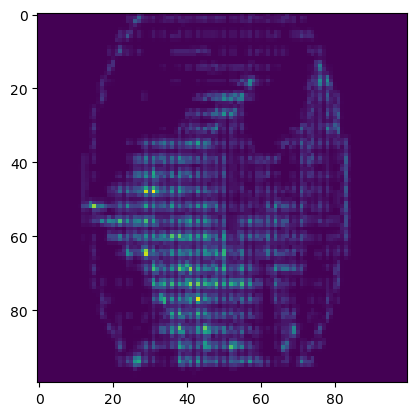

      index        filename  img_width  img_height        class  \
0         0  v01_002075.jpg        596         334      Grasper   
1         1  v01_002250.jpg        596         334      Grasper   
2         2  v01_002250.jpg        596         334      Grasper   
3         3  v01_002425.jpg        596         334      Grasper   
4         4  v01_004050.jpg        596         334      Grasper   
...     ...             ...        ...         ...          ...   
3924   3924  v10_065125.jpg        578         324  SpecimenBag   
3925   3925  v10_065150.jpg        578         324  SpecimenBag   
3926   3926  v10_066100.jpg        578         324  SpecimenBag   
3927   3927  v10_066100.jpg        578         324      Grasper   
3928   3928  v10_066125.jpg        578         324  SpecimenBag   

                                                   data  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0,

In [ ]:


scalify = StandardScaler()
enc=OneHotEncoder()
data = []
for index,row in class_df.iterrows():
    os.chdir(pro_folder)
    image = row['filename']
    img = imread(image, as_gray=True)
    img = resize(img, (100,100))
    if index == 20:
        plt.imshow(img)
        plt.show()
    img = scalify.fit_transform(img)
    if index == 1:
        print(img.shape)
    img = img.flatten()
    if index == 1:
        print(img.shape)
    data.append(img)
class_df['data'] = data
print(class_df)



X_data = list(np.asarray(class_df['data']))
enc.fit(class_df['class'].values.reshape(-1,1))
Y_data = np.asarray(enc.transform(class_df['class'].values.reshape(-1,1)).toarray())

X_train, X_test, y_train, y_test = train_test_split(
    X_data, 
    Y_data, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)
print(len(X_train))
print(len(X_test))

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train,y_train)
predictions=forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rsme=np.sqrt(forest_mse)
print(forest_rsme)

In [ ]:
test_predictions=forest_reg.predict(X_test)
test_forest_mse = mean_squared_error(y_test, test_predictions)
test_forest_rsme=np.sqrt(test_forest_mse)
print(test_forest_rsme)

0.3398159132720267


In [ ]:
print(Y_data)
print(class_df['class'])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0           Grasper
1           Grasper
2           Grasper
3           Grasper
4           Grasper
           ...     
3924    SpecimenBag
3925    SpecimenBag
3926    SpecimenBag
3927        Grasper
3928    SpecimenBag
Name: class, Length: 3929, dtype: object


In [ ]:
label_names = [0,1,2,3,4,5,6]
# print(y_test)
# print(test_predictions)
y_pred = np.argmax(y_test, axis=1)
# print(y_pred)
# print(test_predictions)
cmx = confusion_matrix(y_pred, test_predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
print(df)
print(classification_report(y_pred, test_predictions))

print('Percentage correct: ', 100*np.sum(y_pred == test_predictions)/len(y_test))

prediction   0   1    2   3   4   5   6
label                                  
0           27   0   54   1   1   0   2
1            1  41   39   2   4   4   1
2           36  21  137   2  19  23  54
3            1   5   24  26   3   1   2
4            0   1   27   0  50   0   0
5            0   1   40   1   3  42   0
6            0   0   64   3   0   0  23
              precision    recall  f1-score   support

           0       0.42      0.32      0.36        85
           1       0.59      0.45      0.51        92
           2       0.36      0.47      0.40       292
           3       0.74      0.42      0.54        62
           4       0.62      0.64      0.63        78
           5       0.60      0.48      0.54        87
           6       0.28      0.26      0.27        90

    accuracy                           0.44       786
   macro avg       0.52      0.43      0.46       786
weighted avg       0.47      0.44      0.44       786

Percentage correct:  44.020356234096695


In [ ]:
from sklearn import svm
clf = svm.SVC()
y_train_svm = np.argmax(y_train, axis=1)
clf.fit(X_train, y_train_svm)
clf_y_pred = clf.predict(X_test)

In [ ]:

y_pred = np.argmax(y_test, axis=1)
test_predictions_SVM=clf.predict(X_test)
test_SVM_mse = mean_squared_error(y_pred, test_predictions_SVM)
test_SVM_rsme=np.sqrt(test_SVM_mse)
print(test_SVM_rsme)



1.885393163012654


In [ ]:
cmx_SVM = confusion_matrix(y_pred, test_predictions_SVM, labels=label_names)
df_SVM = pd.DataFrame(cmx_SVM, columns=label_names, index=label_names)
df_SVM.columns.name = 'prediction'
df_SVM.index.name = 'label'
print(df_SVM)
print(classification_report(y_pred, test_predictions_SVM))

prediction   0   1    2   3   4   5   6
label                                  
0           36   0   48   0   1   0   0
1            0  50   36   1   2   3   0
2           12  18  206   1  11  12  32
3            1   1   43  12   3   2   0
4            0   1   31   0  46   0   0
5            0   0   43   2   0  42   0
6            0   1   70   1   0   0  18
              precision    recall  f1-score   support

           0       0.73      0.42      0.54        85
           1       0.70      0.54      0.61        92
           2       0.43      0.71      0.54       292
           3       0.71      0.19      0.30        62
           4       0.73      0.59      0.65        78
           5       0.71      0.48      0.58        87
           6       0.36      0.20      0.26        90

    accuracy                           0.52       786
   macro avg       0.63      0.45      0.50       786
weighted avg       0.57      0.52      0.51       786

